# Instructions on how to run the notebook
The experiments notebook was written in order to work with the olympics 100m dataset.
If running all the blocks in the notebook, all the operations will be performed automatically.

If you want to run the blocks individually, follow the instructions below:
### Performing validation of the model
1. Run block in section 1 to import the necessary libraries
2. Run block in section 2 to prepare the datasets
3. Run blocks in section 3 to perform the validation on the model

### Testing our best model on the test set
1. All the blocks for the validation of the model must be run at least once
2. Run blocks in section 4 to predict on the test set prepared in section 2

### Comparison between our model and sklearn's model
1. All the blocks for the validation of the model must be run at least once
2. Run blocks in section 5 to compare the results of our model and sklearn's model




# 1-Import needed libraries

In [54]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2-Prepare training and test set

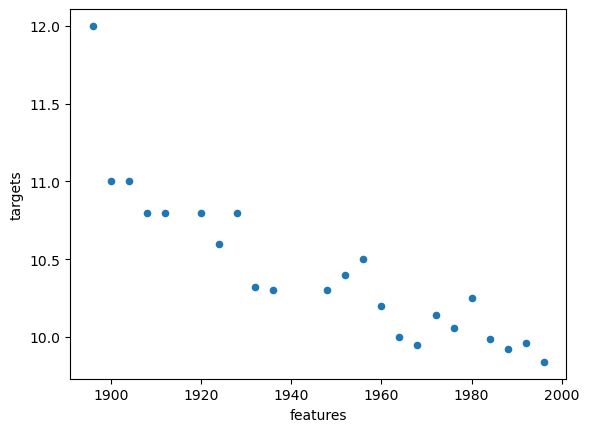

In [55]:
olympics=0
if olympics==0:
    dataset=pd.read_csv('./Data/olympics_100m.csv')
else:
    #create using scikit learn a 2 numerical features dataset with 100 samples from a linear distribution
    from sklearn.datasets import make_regression
    X,Y=make_regression(n_samples=100, n_features=2, noise=100)
    dataset=pd.DataFrame({'features':X[:,0],'features2':X[:,1],'targets':Y})
from sklearn.model_selection import train_test_split
dataset_train,dataset_test=train_test_split(dataset,test_size=0.2, shuffle=False)
X=dataset_train.drop('targets',axis=1).values.reshape(-1,dataset_train.shape[1]-1)
Y=dataset_train['targets'].values.reshape(-1,1)

#plot
if dataset_train.shape[1]==2:
    dataset_train.plot.scatter(x='features',y='targets')

# 3-Perform validation

In [56]:
#coarse to fine approach
from ridge import Ridge_Regression
## given the low amount of data available we wanted to do a K-fold leave-one-out cross validation but, given the time constraint, we had to settle for a Time Series Split Cross-Validation.
## this is taken from this article https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4 where the logic is explained.
## the parameter lambda follows a coarse to fine approach
## the coarse search is done by selecting the magnitude (with a range from 10^10 to 10^-10) and then searching around it
k=int(len(X)/2)
lambda_mses=[]
# generates the intervals for the coarse to fine approach from 10^10 to 10^-10
lambda_values=np.array(10.0 ** np.arange(10, -10, -1))
for lambda_value in lambda_values:
    # print('Lambda value: ',lambda_value)
    ridge=Ridge_Regression(lambda_value)
    mses=[]
    # TODO can't start from 1 because it's not invertible
    for i in range(len(X)-k,len(X),1):
        # K-fold cross validation (take the data from the i-th fold as test data)
        Xi=X[:i]
        Yi=Y[:i]
        ridge.Train(Xi,Yi)
        y_pred=ridge.Predict(X[i].reshape(1,-1))
        mses.append(((Y[i]-y_pred)**2).mean())
    lambda_mses.append(np.mean(mses))
    # print('lambda: ',lambda_value,' mse: ',np.mean(mses))
print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
lambda_value=lambda_values[np.argmin(lambda_mses)]

best lambda atm:  1000.0


In [57]:
# searching around the discovered magnitude to find the best lambda
order_of_magnitude=lambda_value
for order in np.array(10.0 ** np.arange(np.log10(order_of_magnitude)+1, -10, -1)):
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1*order,0),lambda_values[np.argmin(lambda_mses)]+1*order,num=(20+1))
    lambda_mses=[]
    for lambda_value in lambda_values:
        # print('lambda_value: ',lambda_value)
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        # TODO can't start from 1 because it's not invertible
        for i in range(len(X)-k,len(X),1):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi=X[:i]
            Yi=Y[:i]
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i].reshape(1,-1))
            mses.append(((Y[i]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        # print('lambda: ',lambda_value,' mse: ',np.mean(lambda_mses))
    # print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    best_mse = np.min(lambda_mses)
    lambda_value=lambda_values[np.argmin(lambda_mses)]

print('best lambda: ',lambda_value)
print('best mse: ',best_mse)

best lambda:  2548.6512999945
best mse:  0.02172943027849049


# 4-Test the model on test set

In [58]:
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
y_pred=ridge.Predict(X_test)
mse=((Y_test-y_pred)**2).mean()
print('mse on test set: ',mse)

mse on test set:  0.022887067309294132


# 5-Comparison with SciKit Ridge Regression

In [59]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y) ## train on the training dataset
X_test=dataset_test.drop('targets',axis=1).values.reshape(-1,dataset_test.shape[1]-1)
Y_test=dataset_test['targets'].values.reshape(-1,1)
y_pred=ridge.Predict(X_test)
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(X_test)
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',Y_test[i])
for i in range(len(X_test)):
    print('year: ',X_test[i],' time: ',y_pred[i])
    print('scikit: year: ',X_test[i],' time: ',y_pred_sklearn[i])
    
print('w_mio: ',ridge.__str__())
print('w_sklearn: ',ridge_sklearn.coef_,ridge_sklearn.intercept_)
# mse on the test set
print('mse: ',((Y_test-ridge.Predict(X_test))**2).mean())
print('mse sklearn: ',((Y_test-ridge_sklearn.predict(X_test))**2).mean())

year:  [2000]  time:  [9.87]
year:  [2004]  time:  [9.85]
year:  [2008]  time:  [9.69]
year:  [2012]  time:  [9.63]
year:  [2016]  time:  [9.81]
year:  [2020]  time:  [9.8]
year:  [2000]  time:  [9.78577941]
scikit: year:  [2000]  time:  [9.78577941]
year:  [2004]  time:  [9.73642036]
scikit: year:  [2004]  time:  [9.73642036]
year:  [2008]  time:  [9.68706131]
scikit: year:  [2008]  time:  [9.68706131]
year:  [2012]  time:  [9.63770226]
scikit: year:  [2012]  time:  [9.63770226]
year:  [2016]  time:  [9.58834321]
scikit: year:  [2016]  time:  [9.58834321]
year:  [2020]  time:  [9.53898416]
scikit: year:  [2020]  time:  [9.53898416]
w_mio:  ('Ridge Regression model with weights: ', array([[ 3.44653038e+01],
       [-1.23397622e-02]]))
w_sklearn:  [[-0.01233976]] [34.46530376]
mse:  0.022887067309294132
mse sklearn:  0.022887067310203735


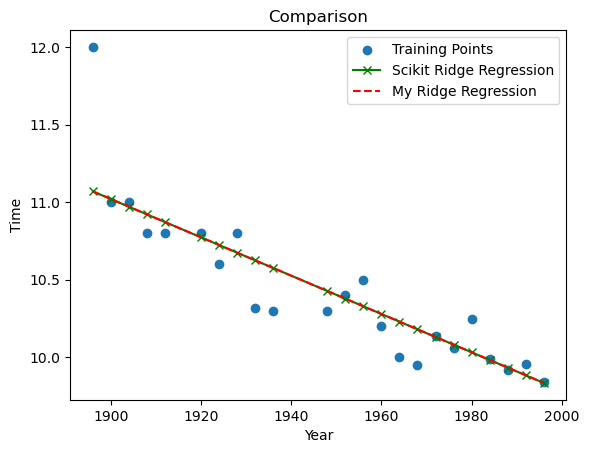

In [60]:
#plot if 1D
import warnings
warnings.filterwarnings('ignore')
if dataset_train.shape[1]==2:
    import matplotlib.pyplot as plt   
    ridge=Ridge_Regression(lambda_value)
    ridge.Train(X,Y)
    y_pred=ridge.Predict(X)
    from sklearn.linear_model import Ridge
    ridge_sklearn=Ridge(alpha=lambda_value)
    ridge_sklearn.fit(X,Y)
    y_pred_sklearn=ridge_sklearn.predict(X)
    from sklearn.linear_model import RidgeCV
    ridge_cv=RidgeCV(cv=k)
    ridge_cv.fit(X,Y)
    y_pred_cv=ridge_cv.predict(X)
    plt.scatter(X, Y, label='Training Points')
    plt.plot(X, y_pred_sklearn, label='Scikit Ridge Regression', color='green', marker="x")
    plt.plot(X, y_pred, label='My Ridge Regression', linestyle='--', color='red')
    
    plt.title('Comparison')
    plt.xlabel('Year')
    plt.ylabel('Time')
    plt.legend()
    plt.show()